In [1]:
from fastai.vision.all import *
import timm
import pdb

In [3]:
def dice(input, targs, iou=False, eps=1e-8,sz=256):
    #threshold for the number of predicted pixels
    noise_th = 75.0*(sz/128.0)**2 
    best_thr0 = 0.2
    n = targs.shape[0]
    #input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = torch.sigmoid(input).view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

# Building Unet on top of Timm and Fast.ai 
- Understanding Unet 
    - Notes from Unet paper
- Build an encoder model using Timm
- Build a Decoder using Fastai & Timm
- Train it using Fastai
- Take advantage of some of the amazing Timm attention layers.
- Areas to explore

![Unet](imgs/Unet.png)

#### Unet paper notes
- Contracting path that captures context & symmetric path enabling precise localisation.
- Built on top of FCN.
    - Contracting Layers + More layers replaced by pooling layers with UpSampling operations.
- Importan contribution of Unet paper is use of a Decoder with a large number of feature channels, which results in decode being simmilar to the contracting (Encoder) path.
- No Fully connected layers.
- More data augmentation since little data is available for medical imaging.

## Building an Encoder using Timm

In [2]:
class Encoder(Module):
    def __init__(self, model_name='resnext50_32x4d'):
        self.encoder = timm.create_model(model_name, features_only=True, pretrained=True)
        
    def forward(self, x):
        return self.encoder(x)

In [7]:
timm_models = timm.list_models(pretrained=True)

In [9]:
timm_models[:4]

['adv_inception_v3', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224']

In [62]:
timm_models.index('resnetrs50')

222

In [63]:
dummy_batch = torch.rand((2,3,224,224))
enc = Encoder('resnetrs50')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs50_ema-6b53758b.pth" to /home/.cache/torch/hub/checkpoints/resnetrs50_ema-6b53758b.pth


In [64]:
for o in enc(dummy_batch):
    print(o.shape)

torch.Size([2, 64, 112, 112])
torch.Size([2, 256, 56, 56])
torch.Size([2, 512, 28, 28])
torch.Size([2, 1024, 14, 14])
torch.Size([2, 2048, 7, 7])


## Building UnetBlock

In [75]:
class Decoder(Module):
    def __init__(self,in_channels,chanels,out_channels,attn=True):
        self.conv1 = ConvLayer(in_channels,chanels)
        self.conv2 = ConvLayer(chanels,out_channels)
        self.attn = attn
        if self.attn:
            self.attn_layer = get_attnn('se')(out_channels)
        
        
    def forward(self,x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = self.conv2(x)
        if self.attn:
            x = self.attn_layer(x)
        return x

In [4]:
from timm.models.layers import create_attn, get_attn

Some of the available timm attention models 
- se
- ese
- eca
- ceca
- cbam
- lcbam

In [7]:
class Decoder(Module):
    def __init__(self,in_channels,chanels,out_channels,attn=None):
        self.conv1 = ConvLayer(in_channels,chanels)
        self.conv2 = ConvLayer(chanels,out_channels)
        self.attn_layer = attn(out_channels) if attn else noop
        
    def forward(self,x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attn_layer(x)
        return x

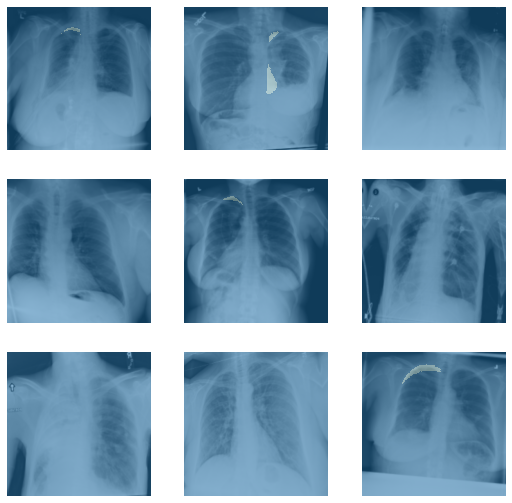

In [14]:
data_path = Path('data/')

data_path.ls()

size=224
bs=64

def get_data(size,tfms=None,bs=64):
    if not tfms:
        tfms = [IntToFloatTensor(div_mask=255),*aug_transforms()]
    db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
                   splitter=RandomSplitter(valid_pct=0.1,seed=2021),
                   batch_tfms=tfms,
                   item_tfms=[Resize(size)],
                   get_items=get_image_files,get_y=lambda o:str(o).replace('images','mask'))
    return db.dataloaders(source=data_path/'train'/'images',bs=bs)

dls = get_data(size=224,bs=64)

dls.show_batch(max_n=9)

### Training using default fastai Unet Learner

In [21]:
dls = get_data(size=224,bs=64)
learn = unet_learner(dls, resnet34, n_out=1, loss_func=BCEWithLogitsLossFlat(),metrics=dice)
learn = learn.to_fp16()
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,dice,time
0,0.021341,0.016086,0.770529,00:55


epoch,train_loss,valid_loss,dice,time
0,0.013366,0.011354,0.781386,00:51
1,0.012464,0.010224,0.790623,00:50
2,0.010341,0.009008,0.809519,00:50
3,0.009022,0.008718,0.810773,00:50
4,0.008377,0.008862,0.806002,00:50


### Building custom Unet Architecture

In [15]:
def calc_hyperfeats(d1,d2,d3,d4,d5):
    hyperfeats = torch.cat((
                         d1,
                         F.interpolate(d2, scale_factor=2, mode='bilinear',align_corners=False),
                         F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=False),
                         F.interpolate(d4, scale_factor=8, mode='bilinear', align_corners=False),
                         F.interpolate(d5, scale_factor=16, mode='bilinear', align_corners=False)), 1)
    return hyperfeats

class UnetDecoder(Module):
    def __init__(self, fs=32, expansion=4,n_out=1, hypercol=False,attn=None):
        center_ch = 512*expansion
        decoder5_ch = center_ch + (256*expansion)
        channels = 512
        self.hypercol = hypercol
        self.center = nn.Sequential(ConvLayer(center_ch,center_ch),ConvLayer(center_ch,center_ch//2))
        self.decoder5 = Decoder(decoder5_ch,channels,fs,attn) 
        self.decoder4 = Decoder((channels//2)*expansion+fs,channels//2,fs,attn) 
        self.decoder3 = Decoder((channels//4)*expansion+fs,channels//4,fs,attn)
        self.decoder2 = Decoder((channels//8)*expansion+fs,(channels//8),fs,attn)
        self.decoder1 = Decoder(fs,fs,fs,attn)
        if hypercol:
            self.logit = nn.Sequential(ConvLayer(fs*5,fs*2),ConvLayer(fs*2,fs),nn.Conv2d(fs,n_out,kernel_size=1))
        else:
            self.logit = nn.Sequential(ConvLayer(fs,fs//2),ConvLayer(fs//2,fs//2),nn.Conv2d(fs//2,n_out,kernel_size=1))
        
    def forward(self, feats):
        e1,e2,e3,e4,e5 = feats #'64 256 512 1024 2048'
        f = self.center(e5)
        d5 = self.decoder5(torch.cat([f, e5], 1))
        d4 = self.decoder4(torch.cat([d5, e4], 1))
        d3 = self.decoder3(torch.cat([d4, e3], 1))
        d2 = self.decoder2(torch.cat([d3, e2], 1))
        d1 = self.decoder1(d2)
        return self.logit(calc_hyperfeats(d1,d2,d3,d4,d5)) if self.hypercol else self.logit(d1)
    
class Encoder(Module):
    def __init__(self, model_name='resnext50_32x4d'):
        self.encoder = timm.create_model(model_name, features_only=True, pretrained=True)
        
    def forward(self, x):
        return self.encoder(x)

        
class Unet(Module):
    def __init__(self, fs=32, expansion=4, model_name='resnext50_32x4d',n_out=1,hypercol=False,attn=None):
        self.encoder = Encoder(model_name)
        self.decoder = UnetDecoder(fs=fs, expansion=expansion,n_out=n_out,hypercol=hypercol,attn=attn)
        
    def forward(self, x):
        feats = self.encoder(x) #'64 256 512 1024 2048'
        out = self.decoder(feats)
        return out

def unet_splitter(m): return L(m.encoder,m.decoder).map(params)

### Using our new Unet

#### Unet 
- IMG_SZ 224
- BS 64
- HyperColumns False

In [16]:
dls = get_data(size=224,bs=64)
learn = Learner(dls,Unet(fs=32,expansion=1,model_name='resnet34'),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /home/.cache/torch/hub/checkpoints/resnet34-43635321.pth


epoch,train_loss,valid_loss,dice,time
0,0.321816,0.223580,0.006456,00:52


epoch,train_loss,valid_loss,dice,time
0,0.167927,0.143535,0.771321,00:48
1,0.087641,0.066241,0.723370,00:48
2,0.046377,0.037232,0.779088,00:48
3,0.032239,0.028651,0.778685,00:49
4,0.028494,0.027046,0.782345,00:48


In [17]:
dls = get_data(size=224,bs=64)
learn = Learner(dls,Unet(fs=32,expansion=1,model_name='resnet34',attn=get_attn('ese')),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.293132,0.163265,0.716975,00:49


epoch,train_loss,valid_loss,dice,time
0,0.112210,0.092652,0.771321,00:49
1,0.048102,0.033872,0.755995,00:49
2,0.024358,0.019129,0.776629,00:47
3,0.017870,0.015827,0.787681,00:48
4,0.016293,0.015057,0.788642,00:50


In [19]:
dls = get_data(size=224,bs=64)
learn = Learner(dls,Unet(fs=32,expansion=4,model_name='resnetrs50',attn=get_attn('ese')),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.374307,0.222531,0.012138,01:24


epoch,train_loss,valid_loss,dice,time
0,0.152511,0.119040,0.737422,01:25
1,0.058157,0.039352,0.783053,01:25
2,0.027107,0.021684,0.744351,01:25
3,0.018543,0.016395,0.791781,01:26
4,0.016321,0.015701,0.793343,01:26


In [20]:
dls = get_data(size=224,bs=64)
learn = Learner(dls,Unet(fs=32,expansion=4,model_name='resnetrs50',attn=get_attn('ese'),hypercol=True),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.223388,0.096562,0.757447,01:39


epoch,train_loss,valid_loss,dice,time
0,0.062124,0.042068,0.777078,01:42
1,0.024995,0.019071,0.718503,01:42
2,0.015295,0.012382,0.776425,01:42
3,0.012368,0.011163,0.788742,01:42
4,0.011413,0.010928,0.802451,01:42


In [22]:
dls = get_data(size=224,bs=64)
learn = Learner(dls,Unet(fs=32,expansion=4,model_name='resnetrs50',attn=get_attn('ese'),hypercol=True),loss_func=BCEWithLogitsLossFlat(), metrics=dice, splitter=unet_splitter)
learn = learn.to_fp16()
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.224602,0.104068,0.767282,01:39


epoch,train_loss,valid_loss,dice,time
0,0.061954,0.041465,0.777678,01:34
1,0.024031,0.016205,0.787668,01:34
2,0.014548,0.012333,0.791513,01:34
3,0.011610,0.010908,0.792903,01:34
4,0.010835,0.010527,0.792021,01:35
